In [9]:
import pygor.filehandling
#import pygor.load
import pygor.strf.analyse

# External
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os 
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
%reload_ext autoreload
%autoreload 2
# Test
user = pathlib.Path(os.getcwd()).parents[-3].stem
user

'Simen'

In [11]:
pkls = pygor.filehandling.find_files_in(".pkl", fr"c:\Users\{user}\OneDrive\Data\Pickles", recursive=True)
loaded = pygor.filehandling.pickleload_objects(pkls)

Iterating through and loading listed .pkl files as objects:   0%|          | 0/17 [00:00<?, ?it/s]

Output()

C:\Users\Simen\Git_repos\pygor\src\pygor\utilities.py:173: UserWarning: Destructive method. You lose data, with no way of recovering original shape!
  warnings.warn("Destructive method. You lose data, with no way of recovering original shape!")


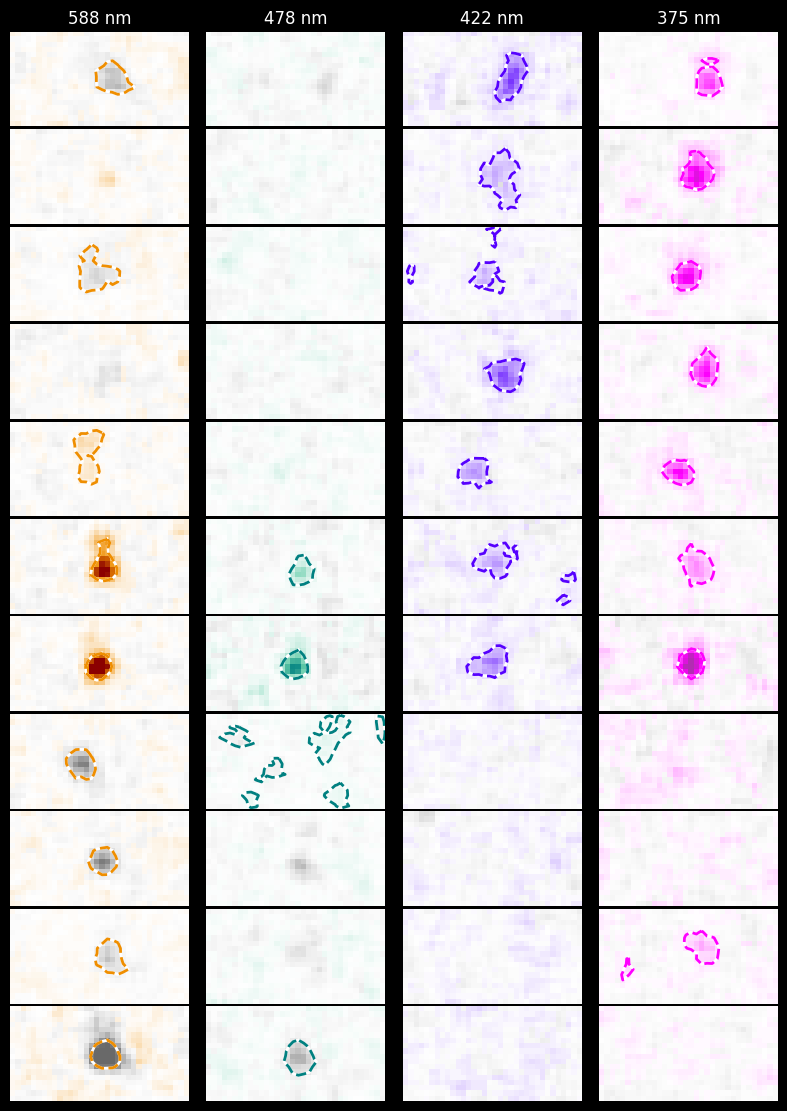

In [12]:
pygor.strf.plot.chroma_overview(loaded[0], None, contours = True)

C:\Users\simen\PhD\pygor\src\pygor\strf\contouring.py:188: UserWarning: Passed array did not meet absolute threshold criteria of 2.5
  contour_lower, contour_upper = _draw_contour_bipolar(arr_2d, abs_criteria)
C:\Users\simen\PhD\pygor\src\pygor\strf\contouring.py:188: UserWarning: Passed array did not meet absolute threshold criteria of 2.5
  contour_lower, contour_upper = _draw_contour_bipolar(arr_2d, abs_criteria)
C:\Users\simen\PhD\pygor\src\pygor\strf\contouring.py:188: UserWarning: Passed array did not meet absolute threshold criteria of 2.5
  contour_lower, contour_upper = _draw_contour_bipolar(arr_2d, abs_criteria)
C:\Users\simen\PhD\pygor\src\pygor\strf\contouring.py:188: UserWarning: Passed array did not meet absolute threshold criteria of 2.5
  contour_lower, contour_upper = _draw_contour_bipolar(arr_2d, abs_criteria)
C:\Users\simen\PhD\pygor\src\pygor\strf\contouring.py:188: UserWarning: Passed array did not meet absolute threshold criteria of 2.5
  contour_lower, contour_up

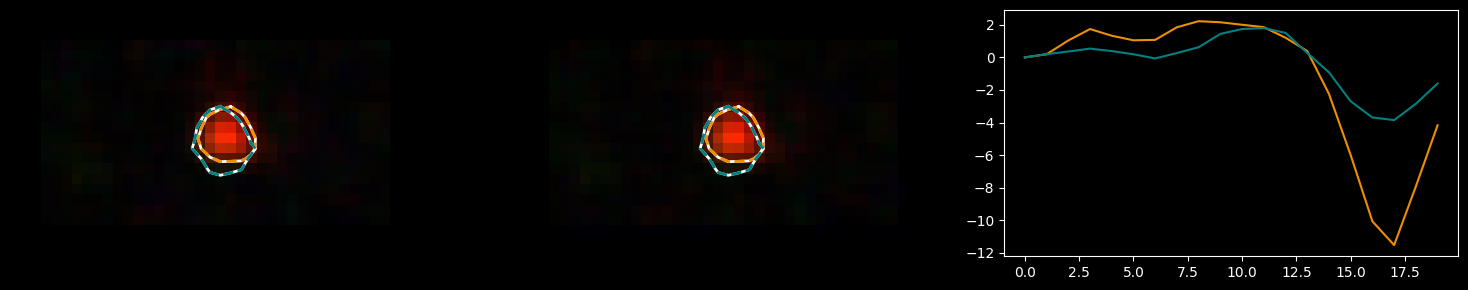

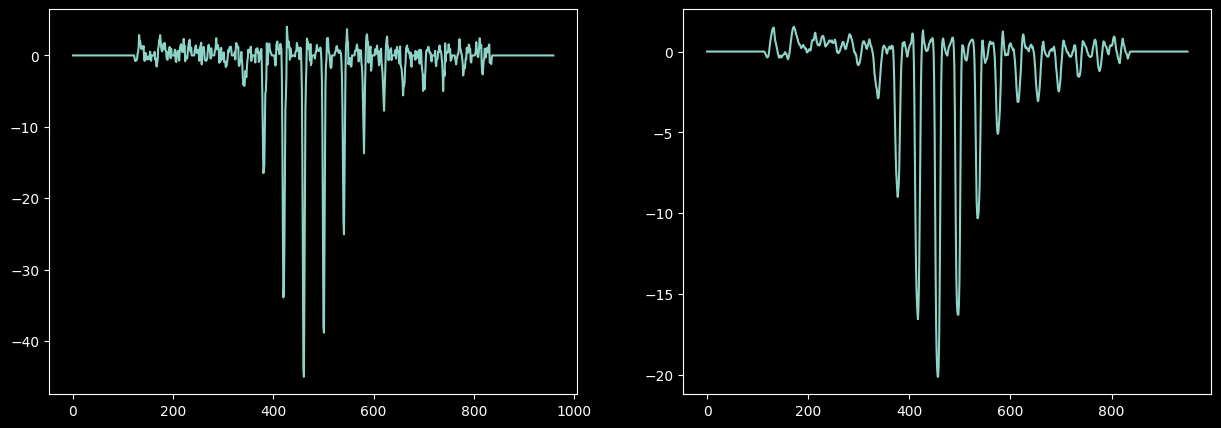

In [4]:



def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

roi = 0
rec = 0
signal = loaded[rec].collapse_times()[roi].data.flatten()
sliding_mean = running_mean(signal, 10)
#sliding_mean_sum = np.sum(sliding_mean)

pygor.strf.plot.visualise_summary(loaded[rec], specify_rois=roi);
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(signal)
ax[1].plot(sliding_mean)
#plt.axhline(sliding_mean_sum, 0, color = "r", alpha = 0.5)

# FAST ICA 

In [14]:
n_c = 10
model = sklearn.decomposition.TruncatedSVD(n_components = n_c, algorithm="arpack")
model.fit(inpu_arr)
s = model.transform(inpu_arr)
biggest_comp = np.unravel_index(np.argmax(np.abs(model.components_)), model.components_.shape)
recovered = model.components_[biggest_comp[0]]

NameError: name 'fig' is not defined

In [184]:
rec = 0
roi = 6
inpu_arr = loaded[rec].get_pix_times()[roi]
n_c = 10
model = sklearn.decomposition.TruncatedSVD(n_components = n_c)
model.fit(inpu_arr)
s = model.transform(inpu_arr)
fig.colorbar(org, ax = ax[1,0])
biggest_comp = np.unravel_index(np.argmax(np.abs(model.components_)), model.components_.shape)
recovered = model.components_[biggest_comp[0]]
# comps = ax[1,1].imshow(model.components_[0].reshape(24, 40))
fig, ax = plt.subplots(3, 2, figsize = (15, 15))
ax[0,0].plot(loaded[rec].get_timecourses()[roi].T)
ax[0,1].plot(s)
org = ax[1,0].imshow(loaded[rec].collapse_times()[roi])
comps = ax[1,1].imshow(recovered.reshape(24, 40))
fig.colorbar(comps, ax = ax[1,1])
ax[2,0].plot(loaded[rec].collapse_times()[roi].data.flatten())
ax[2,1].plot(recovered.flatten())

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [37]:
biggest_comp

(0, 461)

In [38]:
pygor.plotting.play_movie(model.components_.reshape(n_c, 24, 40))

2024-04-24 13:30:51,873 INFO Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [767]:
pygor.plotting.play_movie(loaded[rec].strfs[roi])

2024-04-23 16:17:46,753 INFO Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [532]:
transformed.shape

(20, 2)

# CFAR experimentation

In [52]:
def cfar_detector(x, num_train, num_guard, rate_fa):
    """
    Detect peaks with CFAR algorithm.
    
    num_train: Number of training cells.
    num_guard: Number of guard cells.
    rate_fa: False alarm rate. 
    """
    num_cells = x.size
    num_train_half = round(num_train / 2)
    num_guard_half = round(num_guard / 2)
    num_side = num_train_half + num_guard_half
 
    alpha = num_train*(rate_fa**(-1/num_train) - 1) # threshold factor
    
    peak_idx = []
    for i in range(num_side, num_cells - num_side):
        
        if i != i-num_side+np.argmax(x[i-num_side:i+num_side+1]): 
            continue
        
        sum1 = np.sum(x[i-num_side:i+num_side+1])
        sum2 = np.sum(x[i-num_guard_half:i+num_guard_half+1]) 
        p_noise = (sum1 - sum2) / num_train 
        threshold = alpha * p_noise
        
        if x[i] > threshold: 
            peak_idx.append(i)
    
    peak_idx = np.array(peak_idx, dtype=int)
    
    return peak_idx


In [217]:
import skimage.morphology
import skimage.filters

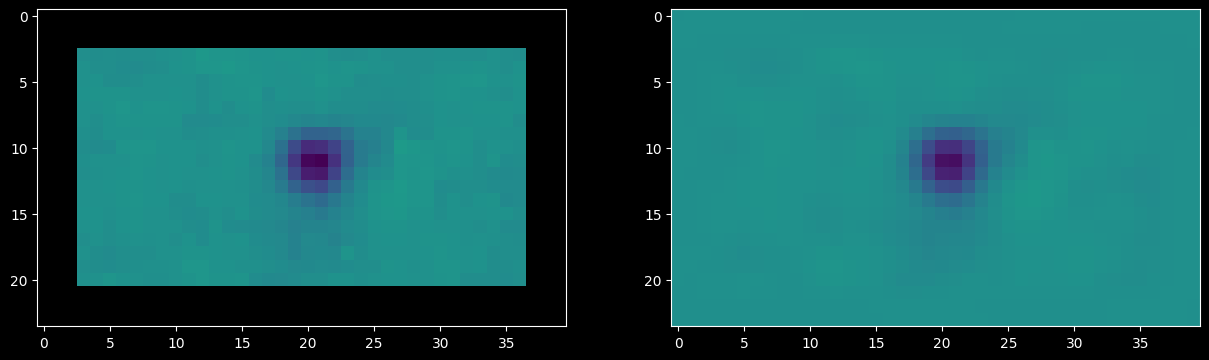

In [234]:
signal_manipulated = skimage.filters.butterworth(loaded[rec].collapse_times()[roi], .3, high_pass = False)
fig, ax = plt.subplots(1, 2, figsize = (15, 7.5))
ax[0].imshow(loaded[rec].collapse_times()[roi])
ax[1].imshow(signal_manipulated)
abs_max = np.max(np.abs(loaded[rec].collapse_times()[roi]))
for ax in ax.flat:
    for im in ax.axes.images:
        im.set_clim(-abs_max, abs_max)

Levelset: 2.3111859821116587 2.3111859821116587


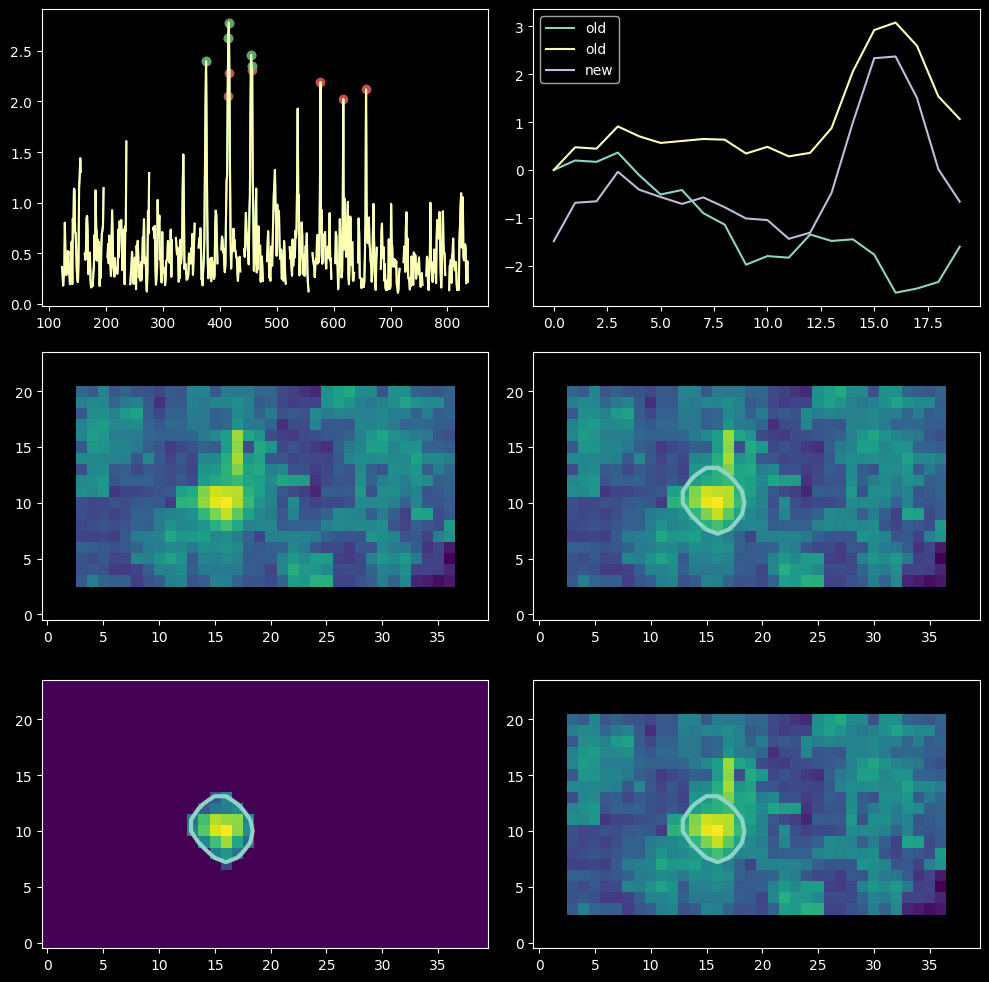

In [1167]:
# Testing
rec = 5
roi = -3
# Give input
signal = loaded[rec].collapse_times()[roi]
#signal = np.clip(loaded[rec].collapse_times()[roi], a_min = None, a_max = 0)
#signal = np.clip(loaded[rec].collapse_times()[roi], a_min = 0, a_max = None)
#signal = np.var(loaded[rec].strfs[roi], axis = 0)
shape = signal.data.shape
# Detect targets
signal_flat_abs = np.abs(signal).flatten()
detected_targets_firstpass = np.where(signal_flat_abs > 2)[0]
if len(detected_targets_firstpass) == 0: 
    detected_targets_secondpass = []
else:
    level_set_abs = np.median(signal_flat_abs[detected_targets_firstpass])
    level_set = np.median(signal.flatten()[detected_targets_firstpass])
    detected_targets_secondpass = np.where(signal_flat_abs > level_set_abs)[0]
# Mask processing
mask = np.ones(len(signal.flatten()))
mask[detected_targets_secondpass] = 0
mask = mask.astype(int).reshape(shape)
mask = skimage.morphology.remove_small_holes(mask, area_threshold = 4)
mask = skimage.morphology.remove_small_objects(mask, min_size = 2)
mask = skimage.morphology.binary_erosion(mask)
mask = skimage.morphology.binary_erosion(mask)
# Apply mask to signal and output 
signal_output = np.copy(signal.flatten())
signal_output[mask.flatten()] = 0
signal_output = signal_output.reshape(shape)
mask_time = np.ma.average(np.ma.masked_array(loaded[rec].strfs[roi], mask = 
    np.repeat(np.expand_dims(mask, axis = 0), 20, axis = 0)), axis = (1, 2))
filter_mask = skimage.filters.gaussian(mask, sigma = 1, mode = "nearest")
# Plot
fig, ax = plt.subplots(3, 2, figsize = (10, 10))
ax[0, 0].plot(np.abs(signal).flatten())
ax[0, 0].plot(signal_flat_abs)
ax[0, 0].scatter(detected_targets_firstpass, signal_flat_abs[detected_targets_firstpass], c="r")
ax[0, 0].scatter(detected_targets_secondpass, signal_flat_abs[detected_targets_secondpass], c="g")
ax[0, 1].plot(loaded[rec].get_timecourses()[roi].T, label = "old")
ax[0, 1].plot(mask_time, label = "new")
ax[0, 1].legend()
ax[1, 0].imshow(loaded[rec].collapse_times()[roi], origin = "lower")
ax[1, 1].imshow(signal.reshape(shape), origin = "lower")
ax[2, 0].imshow(signal_output, origin = "lower")
ax[2, 1].imshow(loaded[rec].collapse_times()[roi], origin = "lower")
#contour = skimage.measure.find_contours(signal_output, level = level_set)
contour = skimage.measure.find_contours(filter_mask, level = .5)
for contour_n in contour:
    ax[1,1].plot(contour_n[:, 1], contour_n[:, 0], lw = 3, ls = '-',)
    ax[2,1].plot(contour_n[:, 1], contour_n[:, 0], lw = 3, ls = '-',)
    ax[2,0].plot(contour_n[:, 1], contour_n[:, 0], lw = 3, ls = '-',)

print("Levelset:", level_set_abs, level_set)
fig.tight_layout()

In [1151]:
pygor.plotting.play_movie(loaded[rec].strfs[roi])

2024-04-24 19:00:29,836 INFO Animation.save using <class 'matplotlib.animation.HTMLWriter'>


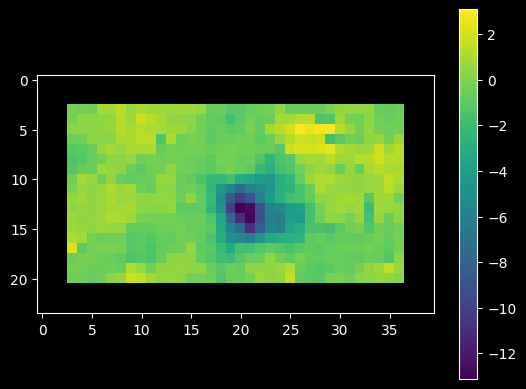

In [1147]:
plt.imshow(signal)
plt.colorbar()